In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


In [3]:
df

,RowID,StateID,WellName,APINo,County,State,LatDegree,LongDegree,SRS,DrillerTotalDepth,...,T491,T492,T493,T494,T495,T496,T497,T498,T499,T500
0,610,KY604,,1.6019E+13,Boyd,KY,38.460130,-82.721020,NAD 83,1735,...,164.7,165.0,165.3,165.5,165.8,166.1,166.4,166.6,166.9,167.2
1,611,KY605,,1.6019E+13,Boyd,KY,38.459500,-82.716841,NAD 83,1738,...,156.4,156.7,156.9,157.2,157.4,157.7,157.9,158.2,158.5,158.7
2,612,KY606,,1.6019E+13,Boyd,KY,38.454476,-82.712581,NAD 83,2151,...,120.5,120.7,120.9,121.1,121.3,121.5,121.7,121.8,122.0,122.2
3,613,KY607,,1.6019E+13,Boyd,KY,38.443355,-82.714851,NAD 83,2139,...,111.6,111.8,111.9,112.1,112.3,112.5,112.7,112.9,113.0,113.2
4,614,KY608,,1.6019E+13,Boyd,KY,38.424684,-82.710950,NAD 83,1893,...,137.5,137.7,137.9,138.1,138.4,138.6,138.8,139.0,139.3,139.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20644,"40,729.00",VA1395,,NaN,TAZEWELL,VA,37.131616,-81.815652,EPSG:4326,2525,...,84.0,84.1,84.2,84.3,84.4,84.5,84.6,84.8,84.9,85.0
20645,"41,096.00",VA934,,VDO_R-036161,RUSSELL,VA,37.034514,-82.137381,EPSG:4326,7092,...,136.9,137.1,137.3,137.6,137.8,138.0,138.2,138.4,138.7,138.9
20646,"41,097.00",VA935,,VDO_R-037979,RUSSELL,VA,36.978792,-82.221254,EPSG:4326,6162,...,140.7,140.9,141.2,141.4,141.6,141.9,142.1,142.3,142.6,142.8
20647,"41,098.00",VA1393,,VDO_T-019191,TAZEWELL,VA,37.266704,-81.378057,EPSG:4326,5315,...,93.9,94.0,94.2,94.3,94.4,94.5,94.7,94.8,94.9,95.0


In [4]:
temp_df = pd.read_csv('Mult0')

In [64]:
lat_vals = temp_df.iloc[:,1].values.reshape(-1,1)
lon_vals = temp_df.iloc[:,0].values.reshape(-1,1)
X_new = np.concatenate((lat_vals,lon_vals),axis=1)

In [23]:
X_old = np.concatenate((df.LatDegree.values.reshape(-1,1),df.LongDegree.values.reshape(-1,1)),axis=1)

In [24]:
X_old

array([[ 38.46013 , -82.72102 ],
       [ 38.4595  , -82.716841],
       [ 38.454476, -82.712581],
       ...,
       [ 36.978792, -82.221254],
       [ 37.266704, -81.378057],
       [ 42.47049 , -78.1599  ]])

# Tuning Part

In [52]:
results = []
for k in [1,2,3,4,5,6,7,8,9,10]:
    for w in [0.001, 0.01, 1]:
        for j in range(0,10):
            X_train, X_test, y_train, y_test = train_test_split(X_old, df.T100.values,
                                                                test_size=0.1, random_state=int(100*np.random.random()))
            def gaussian_kernel(distances):
                    kernel_width = w
                    weights = np.exp(-(distances**2)/kernel_width)
                    return weights
            knn = KNeighborsRegressor(n_neighbors=k,weights=gaussian_kernel)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mae = np.mean(abs(y_pred-y_test))
            rmse = np.sqrt(np.sum((y_pred-y_test)**2/len(y_pred)))
            results.append([k,w,mae,rmse])
results = np.array(results)

Text(0.5, 1.0, 'Tuning KNN')

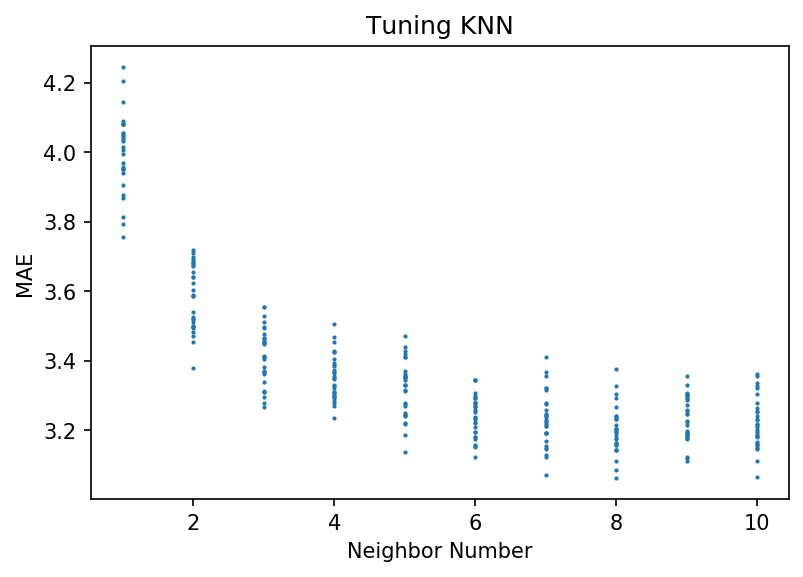

In [53]:
plt.plot(results[:,0],results[:,2], lineStyle = 'none',marker='o',markersize=1)
plt.xlabel('Neighbor Number')
plt.ylabel('MAE')
plt.title('Tuning KNN')

Text(0.5, 1.0, 'Tuning KNN')

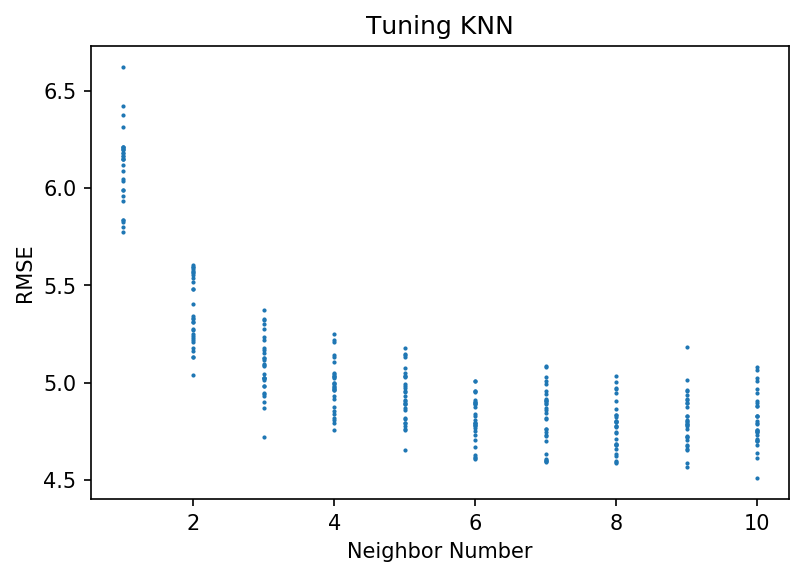

In [54]:
plt.plot(results[:,0],results[:,3], lineStyle = 'none',marker='o',markersize=1)
plt.xlabel('Neighbor Number')
plt.ylabel('RMSE')
plt.title('Tuning KNN')

Text(0.5, 1.0, 'Tuning KNN')

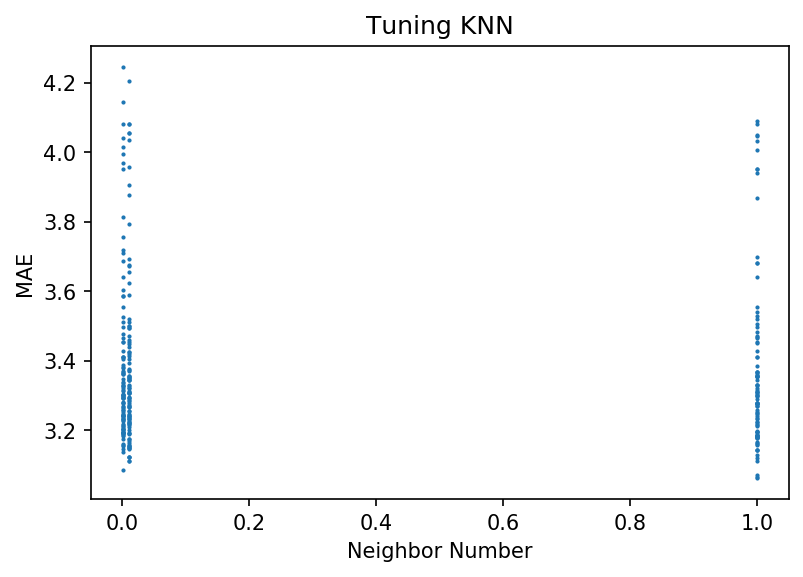

In [55]:
plt.plot(results[:,1],results[:,2], lineStyle = 'none',marker='o',markersize=1)
plt.xlabel('Neighbor Number')
plt.ylabel('MAE')
plt.title('Tuning KNN')

# Plotting Part

In [65]:
from sklearn.neighbors import KNeighborsRegressor
def gaussian_kernel(distances):
                kernel_width = 1
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
knn = KNeighborsRegressor(n_neighbors=8,weights=gaussian_kernel)

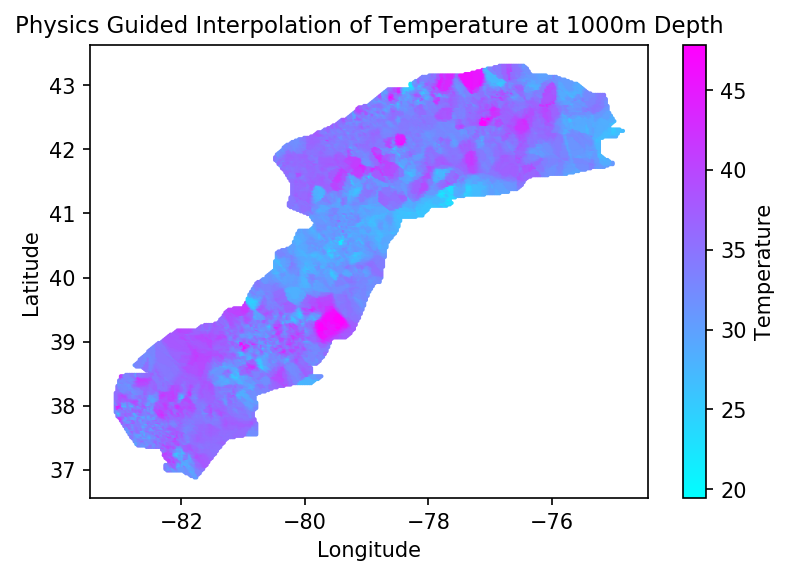

In [66]:
# at 1000m
knn.fit(X_old, df.T100.values)
newY = knn.predict(X_new)
plt.scatter(lon_vals,lat_vals,cmap='cool',c=newY.reshape(-1,1),s=1)
plt.clim(19.447245, 47.82527)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Physics Guided Interpolation of Temperature at 1000m Depth', fontsize=11)
plt.colorbar().set_label('Temperature')

plt.show()

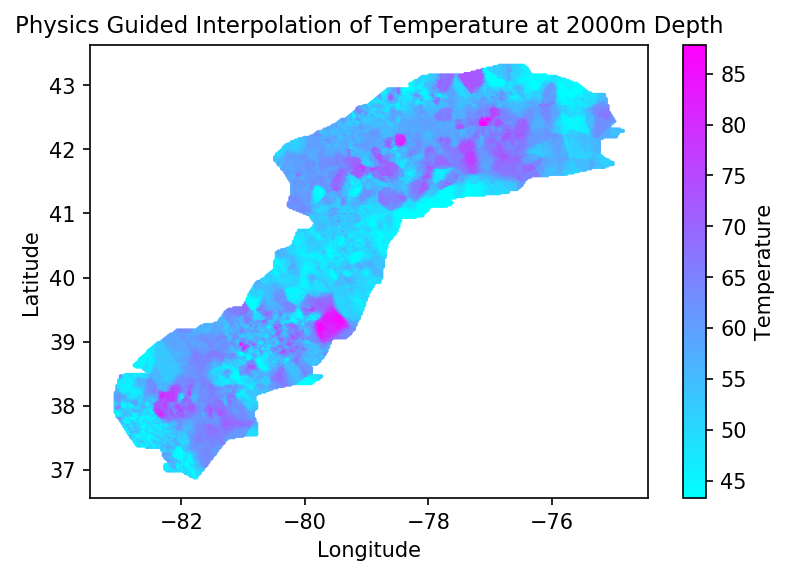

In [67]:
# at 2000m
knn.fit(X_old, df.T200.values)
newY = knn.predict(X_new)
plt.scatter(lon_vals,lat_vals,cmap='cool',c=newY.reshape(-1,1),s=1)
plt.clim(43.279747, 87.82388)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Physics Guided Interpolation of Temperature at 2000m Depth', fontsize=11)
plt.colorbar().set_label('Temperature')
plt.show()

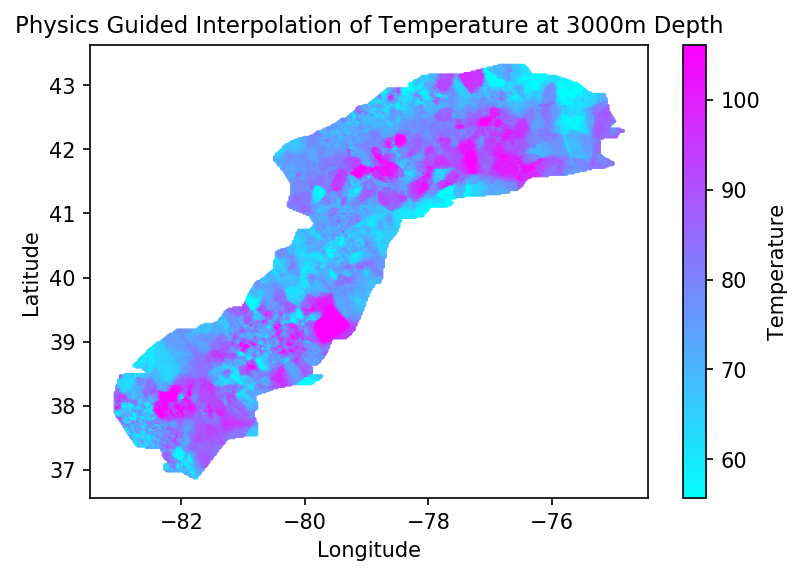

In [68]:
# at 3000m
knn.fit(X_old, df.T300.values)
newY = knn.predict(X_new)
plt.scatter(lon_vals,lat_vals,cmap='cool',c=newY.reshape(-1,1),s=1)
plt.clim(55.67907, 106.08338)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Physics Guided Interpolation of Temperature at 3000m Depth', fontsize=11)
plt.colorbar().set_label('Temperature')
plt.show()